# Graded Assignment 2 - Air Quality and Weather in the Netherlands


# Introduction to This Template Notebook

* This is a **group** notebook.
* Make sure you work in a **copy** of `...-template.ipynb`,
**renamed** to `...-yourIDnrs.ipynb`,
where `yourIDnrs` is the TU/e identification numbers of the members of the group.

<div class="alert alert-danger" role="danger">
<h3>Integrity</h3>
<ul>
    <li>In this course you must act according to the rules of the TU/e code of scientific conduct.</li>
    <li>This exercise or graded assignment is to be executed by the members of the group independently from other people.</li>
    <li>You must not copy from the Internet, your friends, books... If you represent other people's work as your own, then that constitutes fraud and will be reported to the Examination Committee.</li>
    <li>Making your work available to others (complicity) also constitutes fraud.</li>
</ul>
</div>

You are expected to work with Python code and Markdown in this notebook.

Proceed in this notebook as follows:
* **Read** the assignment (separate PDF).
* **Write** your decisions/solutions/interpretations in the appropriate sections.
  * For this you can use both Code and Markdown cells. Information about how to use these cells is available in the _Getting Started_ assignment.
* **Run** _all_ code cells (also the ones _without_ your code),
    _in linear order_ from the first code cell.

**Personalize your notebook**:
1. Copy the following line of code:

  ```python
  AUTHOR_ID_NRS = ['1234567', '2234567', '3234567', '4234567']
  ```
1. Paste them between the marker lines in the next code cell.
1. Fill in the _identification numbers_ of all members of the group as a list of strings between the `Author` markers.
1. Run the code cell by putting the cursor there and typing **Control-Enter**.


In [1]:
#// BEGIN_TODO [Author] Name, Id.nr., Date, as strings (1 point)

AUTHOR_ID_NRS = ['2022982', '1976885', '1986619', '2030950']

#// END_TODO [Author]

## Table of Contents

- [Preparation](#Preparation)
    - [Load the libraries](#Load-the-libraries)
- [Part 1a. Hypothesis selection](#Part-1a:-Hypothesis-selection)
- [Part 1b. Hypothesis refinement](#Part-1b:-Hypothesis-refinement)
- [Part 2. Queries and data cleaning](#Part-2:-Queries-and-data-cleaning)
- [Part 3. Hypothesis testing and interpretation](#Part-3.-Hypothesis-testing-and-interpretation)
- [Part 4. Pitching results](#Part-4.-Pitching-results)

## Preparation
### Load the libraries

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression         # for linear regression
from sklearn.cluster import KMeans                        # for clustering
from sklearn.tree import DecisionTreeClassifier           # for decision tree mining
from sklearn.metrics import mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split
from treeviz import tree_print                            # to print decision tree

import scipy.stats as stats                               # to compute z-scores
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import sqlite3                                            # to interact with the database
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline                                 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns                                     # also improves the look of plots
sns.set()
plt.rcParams['figure.figsize'] = 10, 5                    # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1                 # to fix issue with seaborn box plots; needed after import seaborn

## Part 1a: Hypothesis selection

### Hypothesis
Windspeed has an inverse correlation with NO_x concentrations 
that is greater in Rotterdam than Heerlen

## Part 1b: Hypothesis refinement

### Original hypothesis
Cities with a seaport are more poluted then those without one

### Refining explanation 
Cities under cons,ideration: Rotterdam and Heerlen. \
Rotterdam : it has  the biggest seaport of Europe, but also the most polluting one \
Something to compare : Heerlen \
Heerlen:  it does not have a port and it is far from the sea

Identified major pollutant: NO_x. \
NO_x : it is a pollutant that comes from ships which are mostly found in ports

Key weather factor : Windspeed \
windspeed: from further research we conclude that windspeed is the weather factor with the largest effect on NO_x

Differences are expected between Port and Portless cities.


### Hypothesis refinement
We chose to compare Rotterdam and Heerlen to look at the impact of the Port on the air quality in the cities and from our research we found that one of the major pollutants coming from ships was NO_x. Furthermore, we found the weather factor with the largest effect on NO_x was Windspeed which also varies between Port and Portless cities. 

### Research
The two main pollutants from ships are NO_x and SO_x
(source = https://www.marineinsight.com/maritime-law/what-is-nitrogen-oxides-or-nox-air-pollution-from-ships/).
The seaport of Rotterdam is the biggest of Europe, but also the most polluting one (source = https://www.iamexpat.nl
/expat-info/dutch-expat-news/rotterdam-harbour-found-be-most-polluting-port-europer). Svens research from GA1 showed that 
windspeed has an effect on NO_x. 

## Part 2: Queries and data cleaning

### Helper functions

In [3]:
def get_database_table_names() -> list:
    with sqlite3.connect('datasets/aqw.db') as cnx:
        return pd.read_sql_query("""select name from sqlite_master  
          where type='table';""", cnx)

def get_table_contents(table: str, cols:list="*") -> pd.DataFrame:
    """Return contents of the given table"""
    with sqlite3.connect('datasets/aqw.db') as cnx:
        return pd.read_sql_query(f"""
        select {','.join(cols)}
        from {table}""", cnx)
    
def get_station_code(name:str) -> str:
    """Get the air quality station code for a city"""
    with sqlite3.connect('datasets/aqw.db') as cnx:
        return pd.read_sql_query(f"""
        SELECT code
        FROM air_quality_stations
        WHERE name = '{name}'
        """,cnx).loc[0,'code']

First we explore the database and find what tables there are.

In [4]:
# Worked on this code cell: Jiaqi

# get table names
tables = get_database_table_names()
tables

,name
0,weather_stations
1,weather_data
2,sqlite_sequence
3,air_quality_stations
4,air_quality_data
5,close_stations


Then, we need to get the air quality station codes for Maasslius-Kwarellaan and Heerlen-Looierstraat 

In [5]:
# Worked on this code cell: Sven (refined by Jiaqi)

rotterdam_station_code = get_station_code("Maassluis-Kwartellaan")
heerlen_station_code = get_station_code("Heerlen-Looierstraat")

rotterdam_station_code, heerlen_station_code

('NL01495', 'NL10136')

Now, we find the weather station codes that are close to Maasslius-Kwarellaan and Heerlen-Looierstraat 

In [6]:
# Worked on this code cell: Jiaqi

# get data from close_stations table
df_close_stations = get_table_contents('close_stations')
df_close_stations

,aq_station_code,weather_station_code,distance
0,NL49551,240,20.6
1,NL49553,240,23.4
2,NL10131,375,16.6
3,NL10136,380,14.8
4,NL10138,380,15.8
...,...,...,...
120,NL10545,240,4.2
121,NL10546,240,11.7
122,NL10728,275,18.7
123,NL10743,275,18.0


In [7]:
# Worked on this code cell: Jiaqi

# get weather stations code which are close to the air quality stations
weather_station_heerlen = df_close_stations[(df_close_stations['aq_station_code'] == heerlen_station_code)].reset_index().loc[0,'weather_station_code']
weather_station_rotterdam = df_close_stations[(df_close_stations['aq_station_code'] == rotterdam_station_code)].reset_index().loc[0,'weather_station_code']

weather_station_heerlen, weather_station_rotterdam

('380', '344')

Now we get the contents from the weather_data and air_quality_data tables

In [8]:
# Worked on this code cell: Jiaqi

# get weather data
df_weather = get_table_contents('weather_data', ['station_code', 'datetime', 'wind_speed'])
df_weather

,station_code,datetime,wind_speed
0,235,2012-01-01 00:00:00+01:00,9.0
1,235,2012-01-01 01:00:00+01:00,8.0
2,235,2012-01-01 02:00:00+01:00,8.0
3,235,2012-01-01 03:00:00+01:00,9.0
4,235,2012-01-01 04:00:00+01:00,8.0
...,...,...,...
1315075,380,2021-12-31 19:00:00+01:00,5.0
1315076,380,2021-12-31 20:00:00+01:00,4.0
1315077,380,2021-12-31 21:00:00+01:00,3.0
1315078,380,2021-12-31 22:00:00+01:00,3.0


In [9]:
# Worked on this code cell: Jiaqi

# get air quality data
df_air_quality = get_table_contents('air_quality_data', ['station_code', 'datetime','no_x'])
df_air_quality

,station_code,datetime,no_x
0,NL49551,2012-01-01 01:00:00+01:00,35.20
1,NL49553,2012-01-01 01:00:00+01:00,199.60
2,NL01484,2012-01-01 01:00:00+01:00,NaN
3,NL01485,2012-01-01 01:00:00+01:00,13.45
4,NL01486,2012-01-01 01:00:00+01:00,40.25
...,...,...,...
8600718,NL49557,2021-12-31 23:00:00+01:00,NaN
8600719,NL49570,2021-12-31 23:00:00+01:00,NaN
8600720,NL49572,2021-12-31 23:00:00+01:00,NaN
8600721,NL49573,2021-12-31 23:00:00+01:00,NaN


Now, we filter the dataframes to get the data from our selected stations and finally merge the weather and air quality data frames

In [10]:
# Worked on this code cell: Jiaqi

# filter air quality and weather dataframes for rotterdam
df_aq_rotterdam = df_air_quality[df_air_quality['station_code'] ==  rotterdam_station_code].reset_index()
df_weather_rotterdam = df_weather[df_weather['station_code'] == int(weather_station_rotterdam)].reset_index()

# combine air quality and weather dataframes for rotterdam
df_rotterdam = pd.merge(left=df_aq_rotterdam, right=df_weather_rotterdam, how='inner', on='datetime')[['datetime','no_x','wind_speed']]
df_rotterdam.set_index('datetime', inplace=True)

df_aq_heerlen = df_air_quality[df_air_quality['station_code'] == heerlen_station_code].reset_index()
df_weather_heerlen = df_weather[df_weather['station_code'] == int(weather_station_heerlen)].reset_index()

df_heerlen = pd.merge(left=df_aq_heerlen, right=df_weather_heerlen, how='inner', on='datetime')[['datetime','no_x','wind_speed']]
df_heerlen.set_index('datetime', inplace=True)


### Cleaning the data

First, let us look at the info of the two dataframes

In [11]:
# Worked on this code cell: Jiaqi

df_rotterdam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87671 entries, 2012-01-01 01:00:00+01:00 to 2021-12-31 23:00:00+01:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   no_x        86861 non-null  float64
 1   wind_speed  87671 non-null  float64
dtypes: float64(2)
memory usage: 2.0+ MB


In [12]:
# Worked on this code cell: Jiaqi

df_heerlen.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87671 entries, 2012-01-01 01:00:00+01:00 to 2021-12-31 23:00:00+01:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   no_x        84792 non-null  float64
 1   wind_speed  87671 non-null  float64
dtypes: float64(2)
memory usage: 2.0+ MB


We notice that there are fewer non-null cells in the no_x column than the total number entries. These entries might be empty due to different reasons such as different measurement start and end datetimes (though probably not the reason in our case, since the dataframes are merged using the inner paramater, which takes only the intersection of the two dataframes) or malfunction during the measurements causing them to be not recorded.

For our further analysis we need to remove those entries containing NaN values.

In [13]:
# Worked on this code cell: Jiaqi

# drop nan rows
df_rotterdam.dropna(inplace=True)
df_heerlen.dropna(inplace=True)

Now to inspect further the dataframes

In [14]:
# Worked on this code cell: Jiaqi

df_rotterdam.describe()

,no_x,wind_speed
count,86861.000000,86861.000000
mean,45.617384,4.304579
std,41.766285,2.539674
min,-5.660000,0.000000
25%,20.120000,2.000000
50%,34.890000,4.000000
75%,57.430000,6.000000
max,790.500000,21.000000


In [15]:
# Worked on this code cell: Jiaqi

df_heerlen.describe()

,no_x,wind_speed
count,84792.000000,84792.000000
mean,46.495262,3.922788
std,52.983803,2.195506
min,0.420000,0.000000
25%,16.530000,2.000000
50%,32.060000,4.000000
75%,57.510000,5.000000
max,1172.330000,17.000000


We can notice that the minimum concentration of no_x recorded in rotterdam is -5.66 which is probably a mistake during the measurements, since it's physically impossible to have a negative concentration. We need to remove the cells with negative values.

In [16]:
# Worked on this code cell: Jiaqi

# remove negative values
df_rotterdam = df_rotterdam[df_rotterdam['no_x']>=0]
df_rotterdam.describe()

,no_x,wind_speed
count,86824.000000,86824.000000
mean,45.637387,4.304317
std,41.763932,2.539547
min,0.000000,0.000000
25%,20.140000,2.000000
50%,34.900000,4.000000
75%,57.450000,6.000000
max,790.500000,21.000000


Now, we plot the data to see if there are any irregularities.

<Axes: xlabel='datetime'>

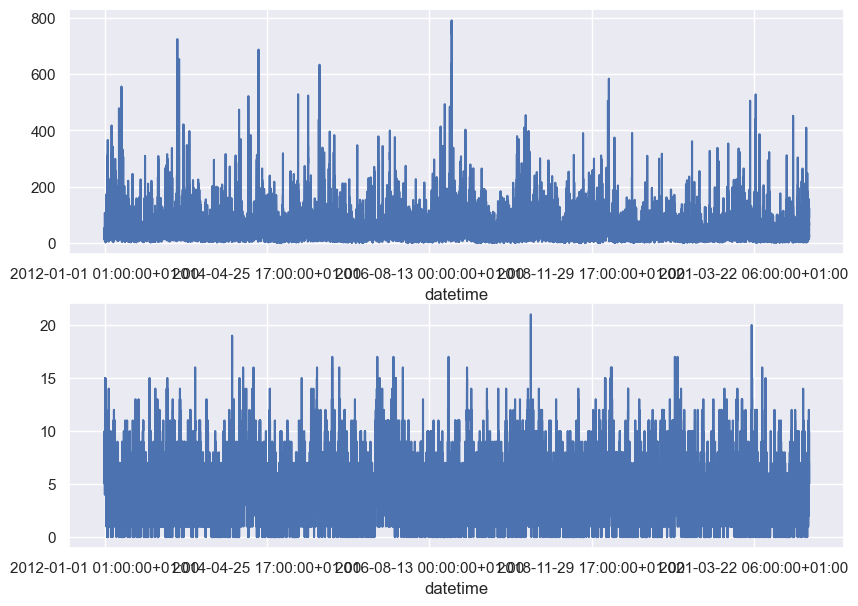

In [17]:
# Worked on this code cell: Jiaqi

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10,7))
df_rotterdam['no_x'].plot(ax=ax[0])
df_rotterdam['wind_speed'].plot(ax=ax[1])

<Axes: xlabel='datetime'>

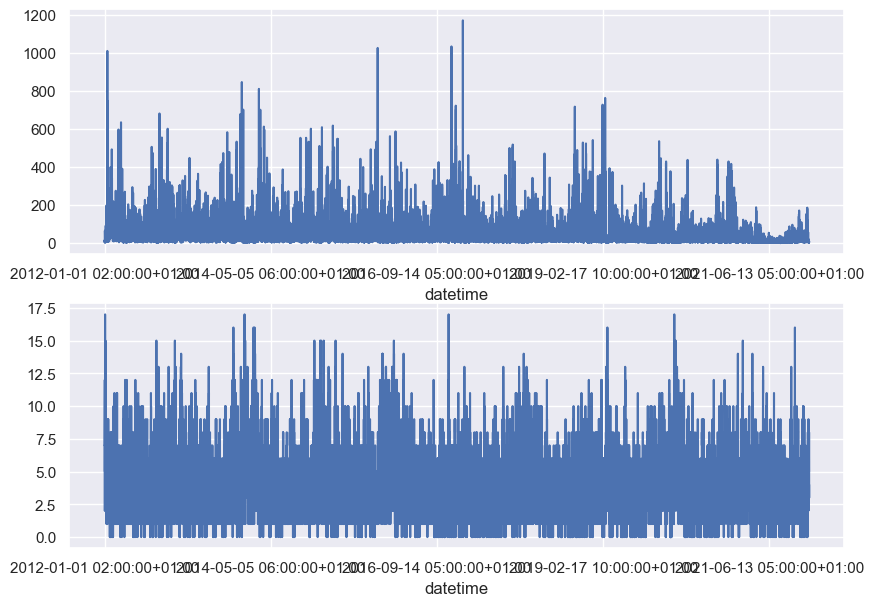

In [18]:
# Worked on this code cell: Jiaqi

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10,7))
df_heerlen['no_x'].plot(ax=ax[0])
df_heerlen['wind_speed'].plot(ax=ax[1])

We can also plot NO_x against wind speed

<Axes: xlabel='wind_speed', ylabel='no_x'>

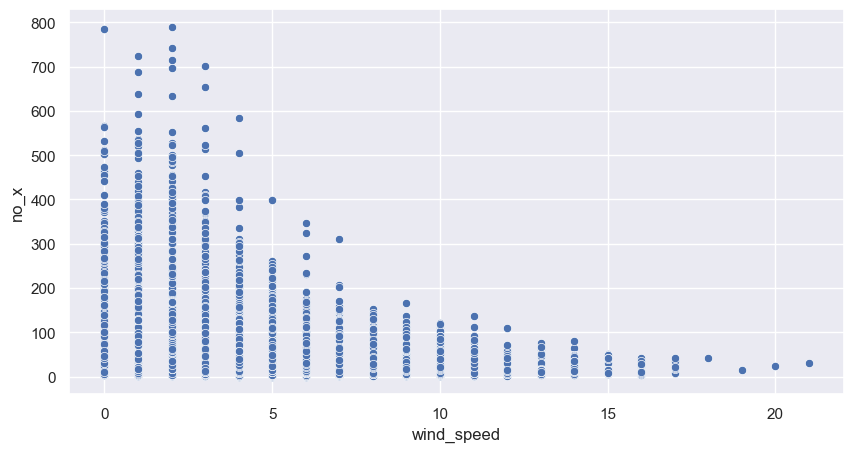

In [19]:
# Worked on this code cell: Jiaqi

sns.scatterplot(data=df_rotterdam, x='wind_speed', y='no_x')

<Axes: xlabel='wind_speed', ylabel='no_x'>

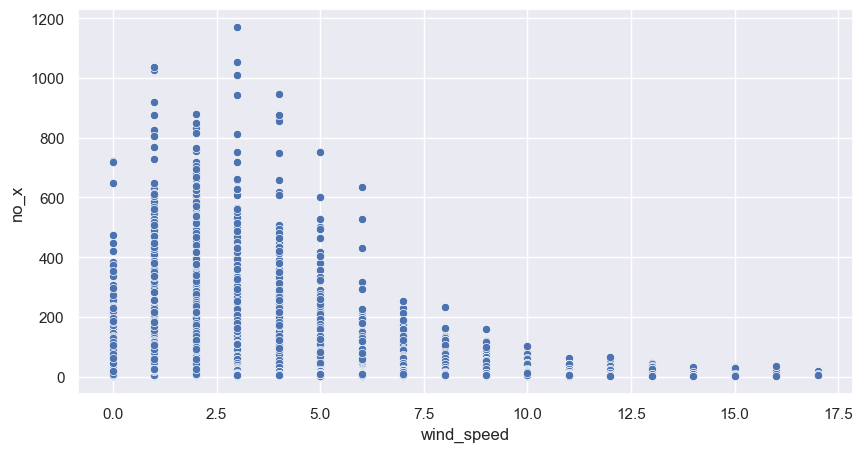

In [20]:
# Worked on this code cell: Jiaqi

sns.scatterplot(data=df_heerlen, x='wind_speed', y='no_x')

## Part 3. Hypothesis testing and interpretation

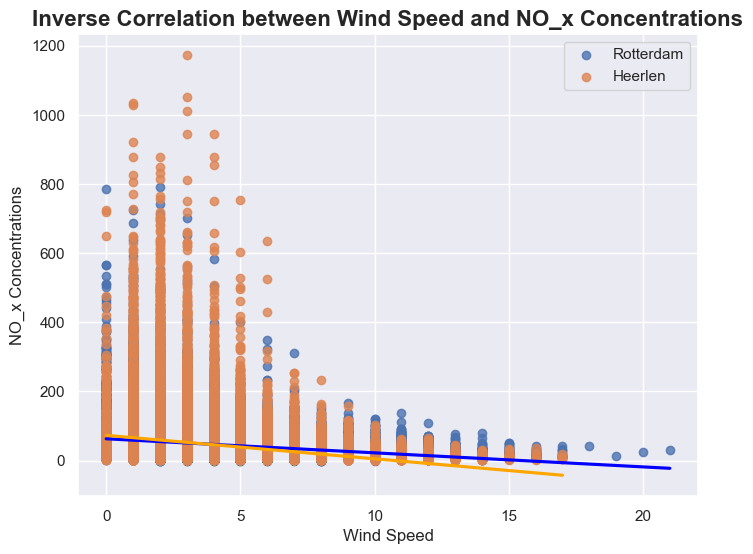

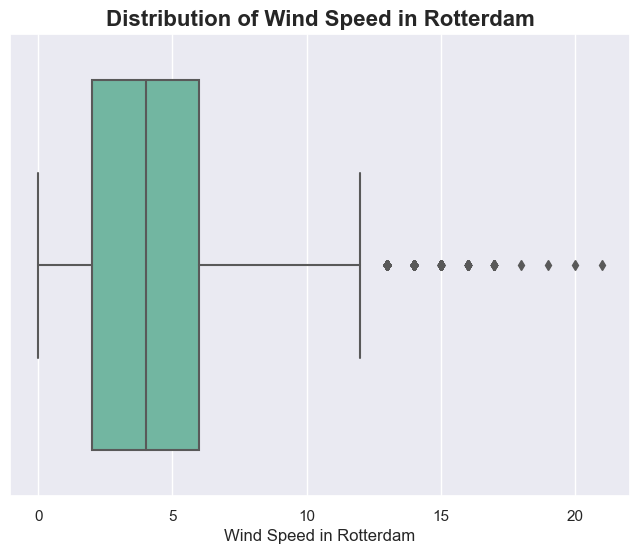

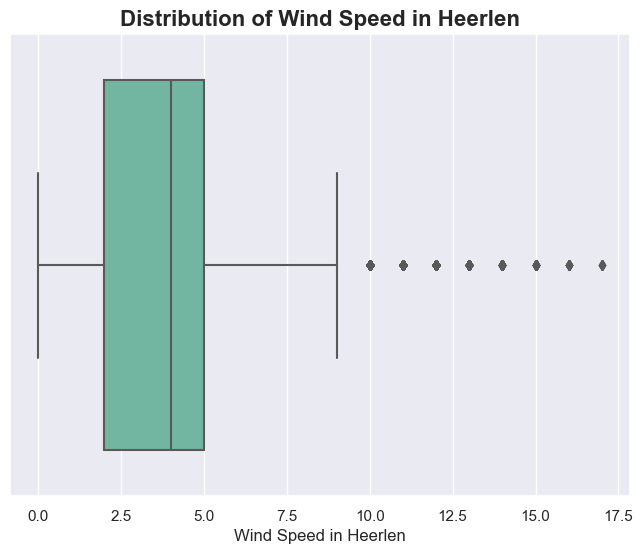

In [21]:
# Worked on this code cell: Sven

#Visualizations of the data
plt.figure(figsize=(8, 6)) #Sven Collins
ax = sns.regplot(x=df_rotterdam['wind_speed'], y=df_rotterdam['no_x'], line_kws={'color': 'blue'}, ci=None, label='Rotterdam')
ax = sns.regplot(x=df_heerlen['wind_speed'], y=df_heerlen['no_x'], line_kws={'color': 'orange'}, ci=None, label='Heerlen')
ax.set_xlabel('Wind Speed')
ax.set_ylabel('NO_x Concentrations')
ax.set_title("Inverse Correlation between Wind Speed and NO_x Concentrations", size=16, weight='bold')
plt.legend()
plt.show()

# Plot a boxplot for Rotterdam
plt.figure(figsize=(8, 6))
ax_rotterdam = sns.boxplot(x=df_rotterdam['wind_speed'], palette='Set2')
ax_rotterdam.set_xlabel('Wind Speed in Rotterdam')
ax_rotterdam.set_title("Distribution of Wind Speed in Rotterdam", size=16, weight='bold')
plt.show()

# Plot a boxplot for Heerlen
plt.figure(figsize=(8, 6))
ax_heerlen = sns.boxplot(x=df_heerlen['wind_speed'], palette='Set2')
ax_heerlen.set_xlabel('Wind Speed in Heerlen')
ax_heerlen.set_title("Distribution of Wind Speed in Heerlen", size=16, weight='bold')
plt.show()

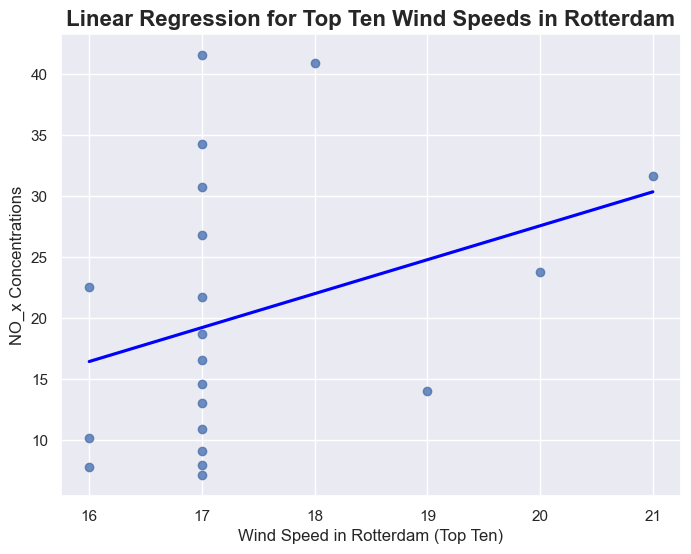

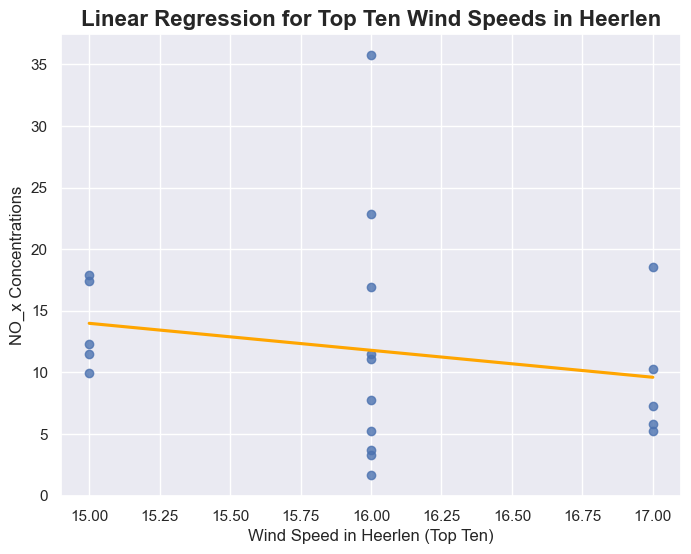

In [22]:
# Worked on this code cell: Sven

sorted_rotterdam = df_rotterdam.sort_values(by='wind_speed', ascending=False)
sorted_heerlen = df_heerlen.sort_values(by='wind_speed', ascending=False)

# top ten records for each city
top_ten_rotterdam = sorted_rotterdam.head(20)
top_ten_heerlen = sorted_heerlen.head(20)

# Scatter plot with linear regression line for Rotterdam
plt.figure(figsize=(8, 6))
ax_rotterdam = sns.regplot(x=top_ten_rotterdam['wind_speed'], y=top_ten_rotterdam['no_x'], line_kws={'color': 'blue'}, ci=None)
ax_rotterdam.set_xlabel('Wind Speed in Rotterdam (Top Ten)')
ax_rotterdam.set_ylabel('NO_x Concentrations')
ax_rotterdam.set_title("Linear Regression for Top Ten Wind Speeds in Rotterdam", size=16, weight='bold')
plt.show()

# Scatter plot with linear regression line for Heerlen
plt.figure(figsize=(8, 6))
ax_heerlen = sns.regplot(x=top_ten_heerlen['wind_speed'], y=top_ten_heerlen['no_x'], line_kws={'color': 'orange'}, ci=None)
ax_heerlen.set_xlabel('Wind Speed in Heerlen (Top Ten)')
ax_heerlen.set_ylabel('NO_x Concentrations')
ax_heerlen.set_title("Linear Regression for Top Ten Wind Speeds in Heerlen", size=16, weight='bold')
plt.show()

## Part 4. Polishing and pitching results

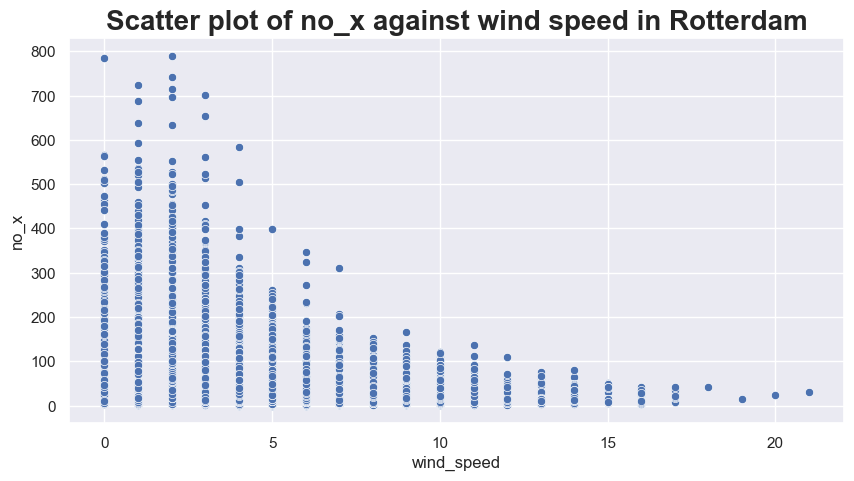

In [23]:
# Worked on these code cells: Jiaqi

# Save plots
sns.scatterplot(data=df_rotterdam, x='wind_speed', y='no_x')
plt.title('Scatter plot of no_x against wind speed in Rotterdam', size=20, weight='bold')
plt.savefig('scatter_nox_against_wind_speed_rotterdam')

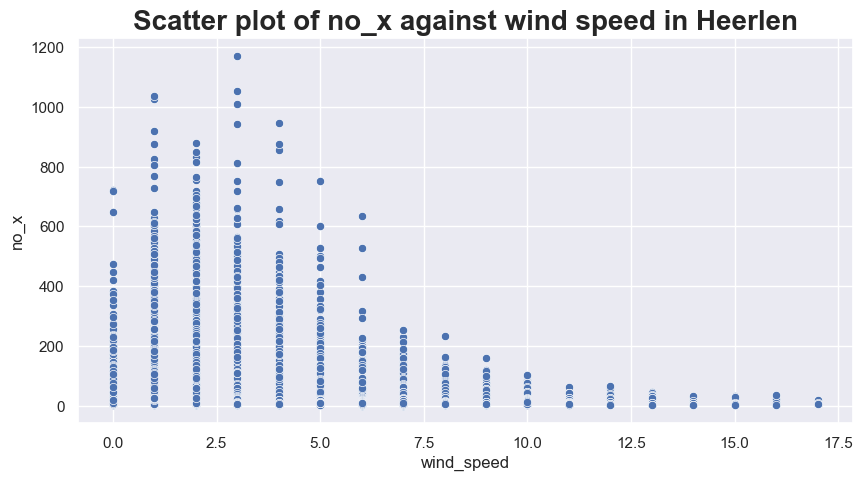

In [24]:
sns.scatterplot(data=df_heerlen, x='wind_speed', y='no_x')
plt.title('Scatter plot of no_x against wind speed in Heerlen', size=20, weight='bold')
plt.savefig('scatter_nox_against_wind_speed_heerlen')

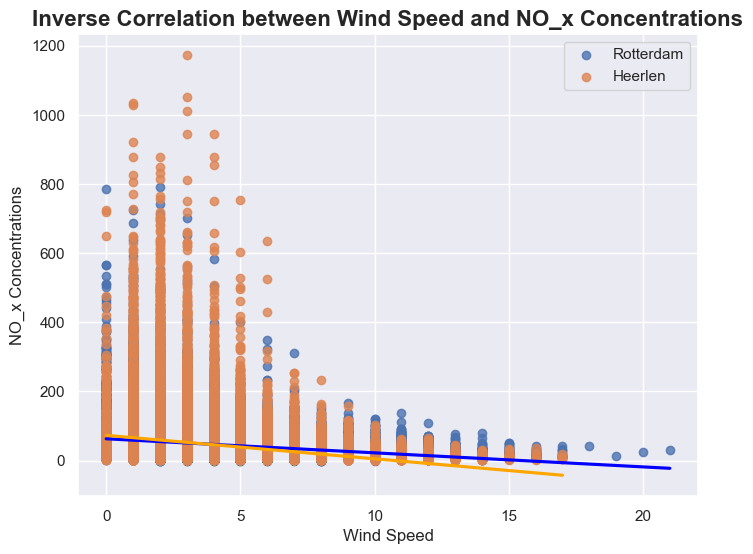

In [25]:
plt.figure(figsize=(8, 6))
ax = sns.regplot(x=df_rotterdam['wind_speed'], y=df_rotterdam['no_x'], line_kws={'color': 'blue'}, ci=None, label='Rotterdam')
ax = sns.regplot(x=df_heerlen['wind_speed'], y=df_heerlen['no_x'], line_kws={'color': 'orange'}, ci=None, label='Heerlen')
ax.set_xlabel('Wind Speed')
ax.set_ylabel('NO_x Concentrations')
ax.set_title("Inverse Correlation between Wind Speed and NO_x Concentrations", size=16, weight='bold')
plt.legend()
plt.savefig('regression_rotterdam_and_heerlen')

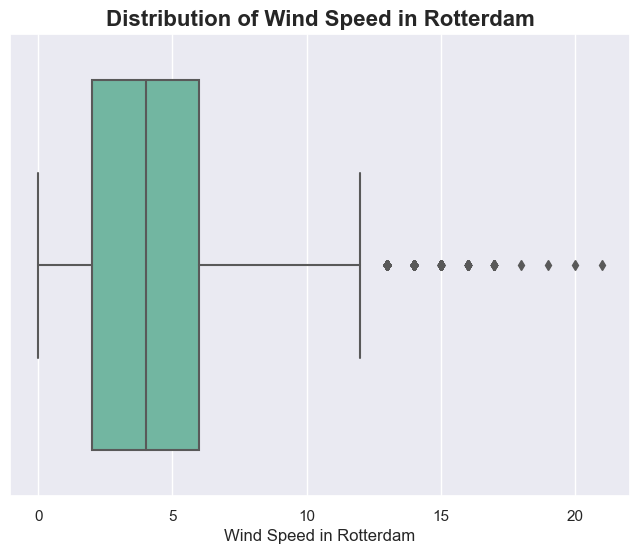

In [26]:
# Plot a boxplot for Rotterdam
plt.figure(figsize=(8, 6))
ax_rotterdam = sns.boxplot(x=df_rotterdam['wind_speed'], palette='Set2')
ax_rotterdam.set_xlabel('Wind Speed in Rotterdam')
ax_rotterdam.set_title("Distribution of Wind Speed in Rotterdam", size=16, weight='bold')
plt.savefig('box_rotterdam')

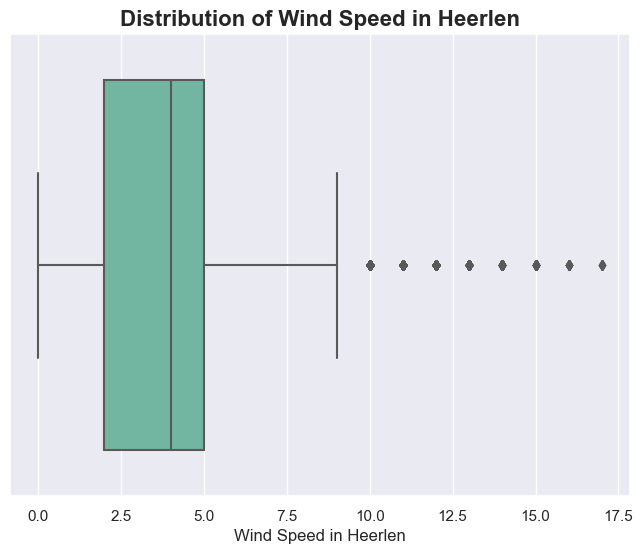

In [27]:
# Plot a boxplot for Heerlen
plt.figure(figsize=(8, 6))
ax_heerlen = sns.boxplot(x=df_heerlen['wind_speed'], palette='Set2')
ax_heerlen.set_xlabel('Wind Speed in Heerlen')
ax_heerlen.set_title("Distribution of Wind Speed in Heerlen", size=16, weight='bold')
plt.savefig('box_heerlen')

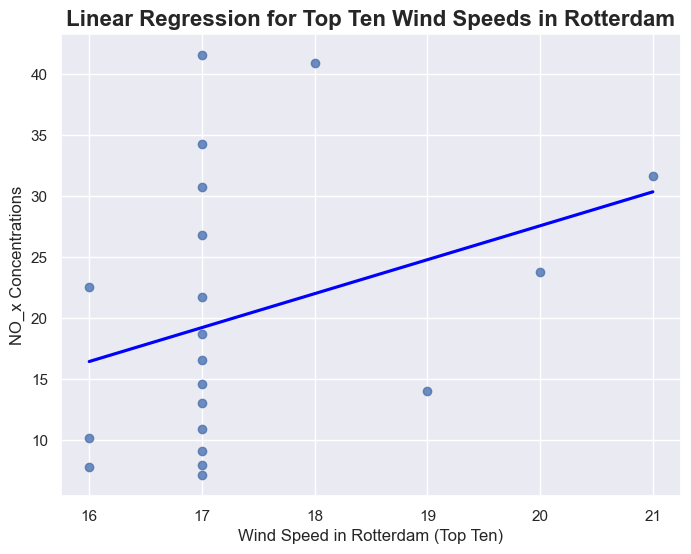

In [28]:
sorted_rotterdam = df_rotterdam.sort_values(by='wind_speed', ascending=False)
top_ten_rotterdam = sorted_rotterdam.head(20)

# Scatter plot with linear regression line for Rotterdam
plt.figure(figsize=(8, 6))
ax_rotterdam = sns.regplot(x=top_ten_rotterdam['wind_speed'], y=top_ten_rotterdam['no_x'], line_kws={'color': 'blue'}, ci=None)
ax_rotterdam.set_xlabel('Wind Speed in Rotterdam (Top Ten)')
ax_rotterdam.set_ylabel('NO_x Concentrations')
ax_rotterdam.set_title("Linear Regression for Top Ten Wind Speeds in Rotterdam", size=16, weight='bold')
plt.savefig('regression_top_10_rotterdam')

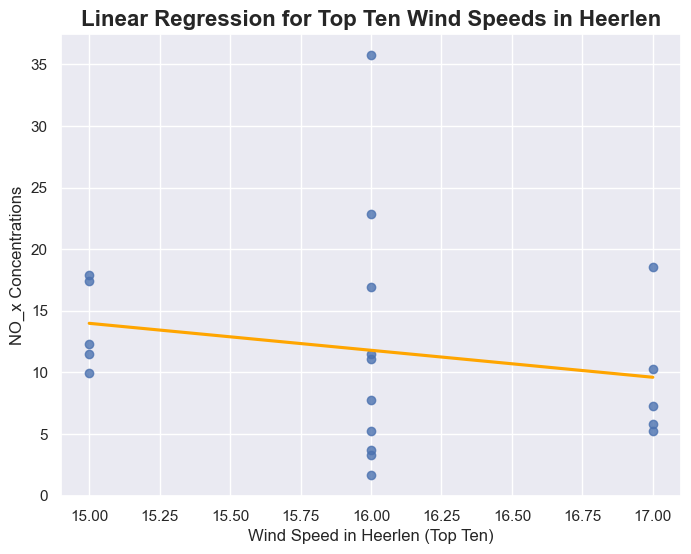

In [29]:
sorted_heerlen = df_heerlen.sort_values(by='wind_speed', ascending=False)
top_ten_heerlen = sorted_heerlen.head(20)

# Scatter plot with linear regression line for Heerlen
plt.figure(figsize=(8, 6))
ax_heerlen = sns.regplot(x=top_ten_heerlen['wind_speed'], y=top_ten_heerlen['no_x'], line_kws={'color': 'orange'}, ci=None)
ax_heerlen.set_xlabel('Wind Speed in Heerlen (Top Ten)')
ax_heerlen.set_ylabel('NO_x Concentrations')
ax_heerlen.set_title("Linear Regression for Top Ten Wind Speeds in Heerlen", size=16, weight='bold')
plt.savefig('regression_top_10_heerlen')

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on these exercises?

Assign a number to `feedback_time`.

In [30]:
#// BEGIN_FEEDBACK [Feedback_1] (0 point)
feedback_time = 45
#// END_FEEDBACK [Feedback_1] (0 point)

import numbers

assert isinstance(feedback_time, numbers.Number), "Please assign a number to feedback_time"
print(feedback_time)

45


### How difficult did you find these exercises?

Assign an integer to `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult.

In [31]:
#// BEGIN_FEEDBACK [Feedback_2] (0 point)
feedback_difficulty = 8
#// END_FEEDBACK [Feedback_2] (0 point)

import numbers

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to feedback_difficulty"
print(feedback_difficulty)

8


### (Optional) What did you like?

Assign a string to `feedback_like`.

In [32]:
#// BEGIN_FEEDBACK [Feedback_3] (0 point)

#// END_FEEDBACK [Feedback_3] (0 point)

### (Optional) What can be improved?

Assign a string to `feedback_improve`. Please be specific, so that we can act on your feedback. For example, mention the specific exercises and what was unclear.

In [33]:
#// BEGIN_FEEDBACK [Feedback_4] (0 point)

#// END_FEEDBACK [Feedback_4] (0 point)




## How to Submit Your Work

1. **Before submitting**, you must run your notebook by doing **Kernel > Restart & Run All**.  
   Make sure that your notebook runs without errors **in linear order**.
1. Remember to rename the notebook as explained at the beginning of this notebook.
1. Submit the executed notebook with your work
   for the appropriate assignment in **Canvas**.
1. In the **Momotor** tab in Canvas,
  you can select that assignment again to find some feedback on your submitted work.
  If there are any problems reported by _Momotor_,
  then you need to fix those,
  and **resubmit the fixed notebook**.

In case of a high workload on our server
(because many students submit close to the deadline),
it may take longer to receive the feedback.




---

In [34]:
# List all defined names
%whos

Variable                    Type         Data/Info
--------------------------------------------------
AUTHOR_ID_NRS               list         n=4
DecisionTreeClassifier      ABCMeta      <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
ECDF                        type         <class 'statsmodels.distr<...>rical_distribution.ECDF'>
KMeans                      ABCMeta      <class 'sklearn.cluster._kmeans.KMeans'>
LinearRegression            ABCMeta      <class 'sklearn.linear_mo<...>._base.LinearRegression'>
ax                          Axes         Axes(0.125,0.11;0.775x0.77)
ax_heerlen                  Axes         Axes(0.125,0.11;0.775x0.77)
ax_rotterdam                Axes         Axes(0.125,0.11;0.775x0.77)
confusion_matrix            function     <function confusion_matrix at 0x7f769b723370>
df_air_quality              DataFrame            station_code     <...>8600723 rows x 3 columns]
df_aq_heerlen               DataFrame             index station_co<...>n[87671 rows x 4 c

---

# (End of Notebook) <span class="tocSkip"></span>

&copy; 2017-2023 - **TU/e** - Eindhoven University of Technology